# Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm

# Connection to drive

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive')

In [4]:
if IN_COLAB:
    os.chdir('/content/gdrive/MyDrive/Tesi/dataset')
else:
    os.chdir('./dataset')

# Downloading, Reading and Merging Data

In [5]:
def move_directories(orig_path, dest_path):
    # Check if the destination folder exists, otherwise create it
    if not os.path.exists(dest_path):
        os.makedirs(dest_path)
    
    # Iter over all files and folders in the source directory
    for item in os.listdir(orig_path):
        orig_item_path = os.path.join(orig_path, item)
        
        # Check if it is a folder
        if os.path.isdir(orig_item_path):
            # Defines the destination path for the folder
            dest_item_path = os.path.join(dest_path, item)
            
            # Move the folder by renaming it
            os.rename(orig_item_path, dest_item_path)
            print(f"Moved directory: {orig_item_path} -> {dest_item_path}")

In [6]:
import kagglehub

# Check if some subdirectories are not empty
path_to_check = "./LUFlow/"
subdirs = [d for d in os.listdir(path_to_check) if os.path.isdir(os.path.join(path_to_check, d))]
non_empty_subdirs = [d for d in subdirs if os.listdir(os.path.join(path_to_check, d))]

dest_path = './LUFlow'

if non_empty_subdirs:
    print("Non-empty subdirectories:", non_empty_subdirs)
    print("Skip downloading.")
else:
    print("All subdirectories are empty.")
    print("Download dataset.")

    # Download latest version
    path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

    print("Path to dataset files:", path)

    move_directories(path, dest_path)

Non-empty subdirectories: ['2021', '2020', '2022']
Skip downloading.


/home/ubdeskiovaro/anaconda3/envs/thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
encoded_dataset = './LUFlow/encoded_dataset.csv'

if os.path.isfile(encoded_dataset):
    print("Encoded dataset is in the directory.")
    ENCODED = True
else:
    print("Encoded dataset is not in the directory.")
    ENCODED = False

Encoded dataset is in the directory.


In [8]:
if not ENCODED:

    df_list = []
    i = 0

    selected_columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']
    dtype_dict = {'bytes_in': np.int32, 'bytes_out': np.int32, 'num_pkts_out': np.int32, 
                  'num_pkts_in': np.int32, 'proto': np.int32, 'time_start': np.int64, 'label': str}

    for root, dirs, files in os.walk(dest_path):
        for file in files:
            # checks if 'file' does not exist in the directory
            # checks if 'csv' is in the file name
            # checks if a particular string is in the file name
            if not os.path.isfile(file) and 'csv' in file:
                chunk_iter = pd.read_csv(os.path.join(root, file), chunksize=10000, usecols=selected_columns, dtype=dtype_dict)
                for chunk in chunk_iter:
                    df_list.append(chunk)
                
                del chunk_iter
                gc.collect()
                i += 1

    df = pd.concat(df_list, ignore_index=True)

    del df_list
    gc.collect()

In [9]:
sorted_dataset = './LUFlow/sorted_encoded_dataset.csv'

if os.path.isfile(sorted_dataset) and ENCODED:
    print("Sorted dataset is in the directory.")
else:
    print("Sorting dataset.")

    dataset_encoded = pd.read_csv(encoded_dataset)
    dataset_encoded_sorted = dataset_encoded.sort_values(by=['time_start'])

    dataset_encoded_sorted.to_csv(sorted_dataset, index=False)

Sorted dataset is in the directory.


In [10]:
QUART = True

if ENCODED and QUART:
    import pandas as pd

    # Count number of lines in the file
    with open(sorted_dataset) as f:
        total_rows = sum(1 for _ in f) - 1  # exclude header

    # Compute the fraction
    n_quarter_rows = total_rows // 70

    # Load only first quarter of the dataset
    df = pd.read_csv(sorted_dataset, nrows=n_quarter_rows)

# Exploratory Data Analysis

In [11]:
import matplotlib.pyplot as plt

if not ENCODED:
    # Count the occurrences of each label
    label_counts = df['label'].value_counts()

    # Plot using Matplotlib
    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

    # Show the plot
    plt.title('Distribution of Labels')
    plt.show()

    print(f"Label counts: {label_counts}")

# Data Preprocessing

In [12]:
df.dropna(axis=1, inplace = True)

missing_values = df.isnull().sum()
print(missing_values)

bytes_in        0
bytes_out       0
num_pkts_out    0
num_pkts_in     0
proto           0
time_start      0
label           0
dtype: int64


In [13]:
if not ENCODED:
    df = df[df['label'].isin(['benign', 'malicious'])].copy()

    df = df.reset_index(drop=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

if not ENCODED:
    label_encoder = LabelEncoder()

    # Fit and transform the label column
    df['label'] = label_encoder.fit_transform(df['label'])

In [15]:
if not ENCODED:
    df.to_csv(encoded_dataset, index=False)

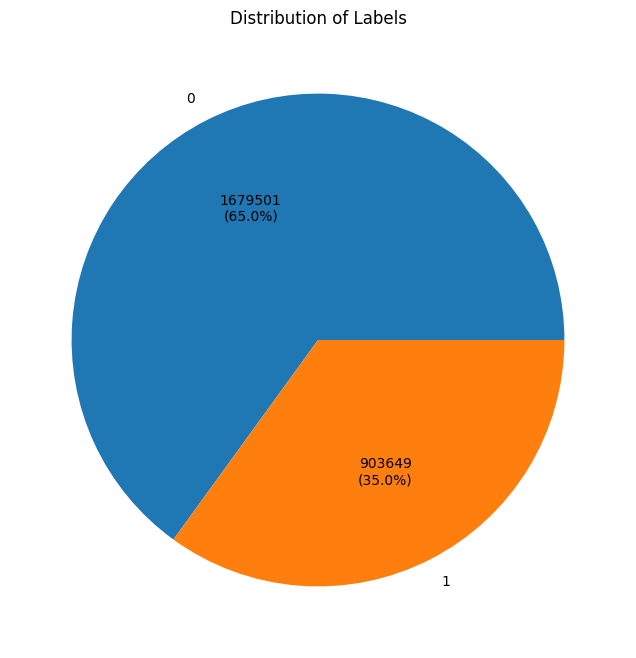

In [16]:
# Count the occurrences of each label
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct=lambda p: '{:.0f}\n({:.1f}%)'.format(p * sum(label_counts) / 100, p))

# Show the plot
plt.title('Distribution of Labels')
plt.show()

In [17]:
df.columns

Index(['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto',
       'time_start', 'label'],
      dtype='object')

### Preparation of index for the granules varying time window dimensions

In [18]:
perc = 0.8

rows_perc = int(len(df)*perc)

df_test = df.iloc[rows_perc:]
df_train = df.iloc[:rows_perc]

In [19]:
if os.path.exists('./LUFlow/GranuleData'):
    GRANULATED = True
else:
    GRANULATED = False
    os.makedirs('./LUFlow/GranuleData')

In [20]:
time_slices = [16, 128, 256, 1024, 2048, 3016]

if not GRANULATED:
  matching_indices_slices = {}

  time_start_values = df['time_start'].values
  n = time_start_values

  for ts in tqdm(time_slices):
    # maximum time limit of the granule
    limit = time_start_values[0] + ts
    # number of granules
    num_gran = 0
    group_dict = {num_gran:[0]}

    for i in range(1, len(n)):
        # if the value of time_start is greater than limit then limit is updated and
        # it is initilized a new granule
        # otherwise the index of the row is added to matching_indeces_slices
        if time_start_values[i] >= limit:
          limit = time_start_values[i] + ts
          num_gran += 1

          group_dict[num_gran] = [i]
        else:
          group_dict[num_gran].append(i)

    matching_indices_slices[ts] = group_dict
    del group_dict
    gc.collect()

100%|██████████| 6/6 [00:27<00:00,  4.61s/it]


In [21]:
# Separate features (X) and target variable (y)
X_train = df.loc[:, df.columns != 'label']
y_train = df['label']

del df
gc.collect()

0

In [22]:
# Separate features (X) and target variable (y)
X_test = df_test.loc[:, df_test.columns != 'label']
y_test = df_test['label']


del df_test
gc.collect()

0

In [23]:
X_train

,bytes_in,bytes_out,num_pkts_out,num_pkts_in,proto,time_start
0,0,7430,6,0,6,15925366400
1,0,10136,7,0,6,15925373126
2,0,2985,3,2,6,15925397203
3,0,5792,4,2,6,15925398899
4,0,3548,3,0,6,15925416267
...,...,...,...,...,...,...
2583145,0,11584,8,2,6,159331573443192
2583146,0,13032,9,0,6,159331573474014
2583147,0,1448,1,0,6,159331573474021
2583148,0,3042,3,0,6,159331573474022


In [24]:
y_train

0          0
1          0
2          0
3          0
4          0
          ..
2583145    0
2583146    0
2583147    0
2583148    0
2583149    0
Name: label, Length: 2583150, dtype: int64

# Model Training and Performance

In [25]:
import time

columns = ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start', 'label']

if not GRANULATED:

    for time_slice in time_slices:

        df = pd.DataFrame(columns=columns)
        df.to_csv(f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv', index=False)

        for granule, granule_indeces in tqdm(matching_indices_slices[time_slice].items()):
            granule_data = X_train.loc[granule_indeces, ['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto', 'time_start']]
            granule_data_y = y_train.loc[granule_indeces]
            
            N = len(granule_data)
            
            if N > 1:
                # Vectorized aggregation for sum and start time extraction
                row = granule_data[['bytes_in', 'bytes_out', 'num_pkts_out', 'num_pkts_in', 'proto']].sum()
                
                row['time_start'] = granule_data['time_start'].iloc[0]
                
                # Vectorized mode calculation
                row['label'] = granule_data_y.mode().iloc[0]
            else:
                row = granule_data.iloc[0]
                row['label'] = granule_data_y.iloc[0]

            row = pd.DataFrame([row])
            row.to_csv(f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv', mode='a', index=False, header=False)

        del granule_data, granule_data_y, row
        # gc.collect()


  0%|          | 371/2422345 [00:28<51:12:44, 13.14it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import math

list_reports = {}
best_models = {}
bcc_reports = {}
mcc_reports = {}

# Random Forest with GridSearchCV
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='accuracy')


for time_slice in tqdm(time_slices):
  granulated_file = f'./LUFlow/GranuleData/clustering_granules_{time_slice}.csv'
  granulated_data = pd.read_csv(granulated_file)

  x_train = granulated_data.loc[:, granulated_data.columns != 'label']
  y_train_list = list(granulated_data['label'])

  list_reports[time_slice] = {}
  best_models[time_slice] = {}

  rf_grid.fit(x_train, y_train_list)
  rf_best_model = rf_grid.best_estimator_

  rf_pred = rf_best_model.predict(X_test)
  report = classification_report(y_test, rf_pred, output_dict=True)

  tn, fp, fn, tp = confusion_matrix(y_test, rf_pred).ravel()

  bcc_reports[time_slice] = (tp/(tp+fn) + tn/(tn+fp))/2

  numerator = (tp*tn - fp*fn)
  try:
      log_denominator = 0.5 * (np.log(tp + fp) + np.log(tp + fn) + np.log(tn + fp) + np.log(tn + fn))
      denominator = np.exp(log_denominator)

      # Safely handle the division, in case the denominator is zero
      mcc_reports[time_slice] = numerator / denominator if denominator != 0 else float('inf')
  except ValueError:
      # Handle cases where log is taken on a zero or negative value
      mcc_reports[time_slice] = float('nan')


  list_reports[time_slice] = pd.DataFrame(report).transpose()
  best_models[time_slice] = rf_best_model


# Model Performance

The performance metrics used by the approach proposed in [8]:
-	Accuracy is the proportion of accurately classified datapoints in the test set in relation to the total number of instances.
-	Precision is the ratio of detected positive cases to all expected positive instances.
-	Recall is the ratio of samples classified as positive to all expected positive instances.
-	F1-score is a harmonic mean of recall and precision.
-	MCC (Matthews Correlation Coefficient) determines the correlation coefficient between the anticipated and actual classifications.
-	BCC (Balanced Accuracy) is used for situations with data imbalance.

In [28]:
# Go up one directory
os.chdir('..')

# Check if 'reports' directory exists, otherwise create it
if not os.path.exists('reports'):
    os.mkdir('reports')

# Check if 'best_models' directory exists, otherwise create it
if not os.path.exists('best_models'):
    os.mkdir('best_models')

In [ ]:
import time
import joblib

subset = 'all'
string = 'clustering_'+subset+'_'+time.strftime("%Y%m%d-%H%M%S")


os.mkdir(f'./reports/{string}')
os.mkdir(f'./best_models/{string}')

os.chdir(f'./reports/{string}')

for report in list_reports:
  list_reports[report].to_csv(f'report_{report}.csv')

columns = ['time_slice', 'BCC', 'MCC']
df = pd.DataFrame(columns=columns)
for time_slice in time_slices:
  row = {'time_slice': time_slice, 'BCC': bcc_reports[time_slice], 'MCC': mcc_reports[time_slice]}
  row = pd.DataFrame([row])
  row.to_csv('bcc_mcc.csv', mode='a', header=False, index=False)

os.chdir(f'../../best_models/{string}')

for model in best_models:
  joblib.dump(best_models[model], f'model_{model}_{string}.joblib')

In [ ]:
equidistant_x = np.arange(len(time_slices))
feature_to_print = 'precision'

plt.plot(equidistant_x, [list_reports[i].loc['accuracy'][feature_to_print] for i in time_slices])

plt.title(f'{feature_to_print} over time_slices')
plt.xticks(equidistant_x, time_slices)
plt.xlabel('time slices')
plt.ylabel(f'{feature_to_print}')
# plt.legend()
plt.show()

In [ ]:
for time_slice in time_slices:
  print(f'Report {time_slice}: \n{list_reports[time_slice]}\n')
  print(f'BCC {time_slice}: {bcc_reports[time_slice]}\n')
  print(f'MCC {time_slice}: {mcc_reports[time_slice]}')
  print('\n')